# Install Dependendcies

In [ ]:
!pip3 install transformers

In [ ]:
!nvidia-smi

Sat Feb 26 08:13:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# !ln -s /content/gdrive/My\ Drive/ /mydrive
# !ls /mydrive

# Download the Dataset

In [ ]:
!gdown --id 1-n9aJG1zdWHL0UjuRWwa8Rro-ogoWxN7
!unzip deception_dataset.zip && rm deception_dataset.zip && rm -r __MACOSX

Downloading...
From: https://drive.google.com/uc?id=1-n9aJG1zdWHL0UjuRWwa8Rro-ogoWxN7
To: /content/deception_dataset.zip
100% 2.87M/2.87M [00:00<00:00, 77.9MB/s]
Archive:  deception_dataset.zip
replace deception_dataset/restaurant/truthful/29.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
   creating: __MACOSX/
   creating: __MACOSX/deception_dataset/
   creating: __MACOSX/deception_dataset/restaurant/
   creating: __MACOSX/deception_dataset/restaurant/truthful/
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._29.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._15.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._114.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._100.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._128.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._129.txt  
  inflating: __MACOSX/deception_dataset/restaurant/truthful/._101.txt  
  inflating: __MACOSX/deception_d

# Data Helpers

In [ ]:
import numpy as np
import string
import os
import io
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SEQUENCE_LEN = 200


def read_from_dir(in_fold_dir):
    reviews = []
    for filename in os.listdir(in_fold_dir):
        if filename.endswith(".txt"):
            # read from file containing the text review
            in_filepath = in_fold_dir + filename
            with io.open(in_filepath, 'r', encoding='windows-1252') as f:
                review = f.read()
                # if len(review) > SEQUENCE_LEN:
                #     review = review[:200]
                reviews.append(review)    

    # print("number of reviews: {}, name: {}".format(len(reviews), in_fold_dir)) 
    print(reviews[:2])         
    return reviews


def load_data():
    trustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/truthful/') 
    trustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/truthful/')
    trustworthy_restaurant = read_from_dir('deception_dataset/restaurant/truthful/')
    trustworthy_doctor = read_from_dir('deception_dataset/doctor/truthful/')[:200]

    untrustworthy_hotel_positive = read_from_dir('deception_dataset/hotel/positive/deceptive_turker/')
    untrustworthy_hotel_negative = read_from_dir('deception_dataset/hotel/negative/deceptive_turker/') 
    untrustworthy_hotel_expert_positive =  read_from_dir('deception_dataset/hotel/positive/deceptive_expert/')
    untrustworthy_hotel_expert_negative =  read_from_dir('deception_dataset/hotel/negative/deceptive_expert/')
    
    untrustworthy_restaurant = read_from_dir('deception_dataset/restaurant/deceptive_MTurk/')[:200]
    untrustworthy_doctor = read_from_dir('deception_dataset/doctor/deceptive_MTurk/')

    TRUSTWORTHY_REVIEWS_DICT = {}
    UNTRUSTWORTHY_REVIEWS_DICT = {}

    TRUSTWORTHY_REVIEWS_DICT["cross_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["cross_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor[:200]
    }

    TRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = {
        "hotel":trustworthy_hotel_positive + trustworthy_hotel_negative,
        "restaurant":trustworthy_restaurant,
        "doctor":trustworthy_doctor
    }

    UNTRUSTWORTHY_REVIEWS_DICT["mixed_domain"] = { 
        "hotel":untrustworthy_hotel_positive + untrustworthy_hotel_expert_positive + untrustworthy_hotel_negative + untrustworthy_hotel_expert_negative,
        "restaurant":untrustworthy_restaurant,
        "doctor":untrustworthy_doctor
    }

    return TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT


TRUSTWORTHY_REVIEWS_DICT, UNTRUSTWORTHY_REVIEWS_DICT = load_data()

["This lovely hotel has only six floors, making it easy to get to elevators and down to reception. The building is dwarfed amongst all the skyscrapers around it. Trump's huge new tower is just down the street. The Amalfi looks recently refurbished, very modern, but warm and inviting. Bedrooms quite spacious with lovely linens and very, very comfortable beds. Bathroom quite small but roomy enough, with Aveda tolietries and constant hot water in the showers. Continental style breakfast is set out fresh every morning in front of the elevator of every floor. Great to stumble out of bed and grab a coffee etc (robes & slippers provided) without having to get dressed for a formal breakfast. Really enjoyed the Managers evening cocktail reception, especially the Amalfitinis. A nice way to relax after a hard days' shopping! Location is great for all the shops, transport, museums etc. Easy walking to everywhere. Staff also very friendly and welcoming. Would definately stay there again. \n", 'This

In [ ]:
def get_reviews_from_dict(reviews_dict, keys = []):
    if not keys:
        raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")

    reviews = []
    for key in keys:
        if key in reviews_dict:
            reviews += reviews_dict[key]
        else:
            raise Exception("Invalid key: key must be one of the following: \'hotel\', \'restaurant\', \'doctor\'")
    return reviews

def get_reviews(review_type="", keys = [], data_name="cross_domain"):
    if not review_type:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")
    if not keys:
        raise Exception("Invalid key: key must be one of the follwowing: \'hotel\', \'restaurant\', \'doctor\'")

    if review_type=="trustworthy":
        return get_reviews_from_dict(reviews_dict=TRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    elif review_type=="untrustworthy":
        return get_reviews_from_dict(reviews_dict=UNTRUSTWORTHY_REVIEWS_DICT[data_name], keys=keys)
    else:
        raise Exception("Invalid review_type: review_type must be either \'trustworthy\' or \'untrustworthy\'.")


def get_data(keys=[], data_name="cross_domain"):
    if data_name != "cross_domain" and data_name != "mixed_domain":
        raise Exception("Invalid dataset name")

    trustworthy_reviews   = get_reviews(review_type="trustworthy", keys=keys, data_name=data_name)
    untrustworthy_reviews = get_reviews(review_type="untrustworthy", keys=keys, data_name=data_name)
    
    reviews = trustworthy_reviews + untrustworthy_reviews

    # generate labels
    labels_trustworthy   = [[1,0] for _ in range(len(trustworthy_reviews   ))]
    labels_untrustworthy = [[0,1] for _ in range(len(untrustworthy_reviews ))]
    labels = labels_trustworthy + labels_untrustworthy

    print("dataset_name: {}".format(data_name+"_"+keys[0]))
    print("trustworthy_reviews: {}".format(len(trustworthy_reviews)))
    print("untrustworthy_reviews: {}".format(len(untrustworthy_reviews)))
    print("reviews len: ", len(reviews))
    print("labels len: ", len(labels))
    print()
        
    return reviews, labels

In [ ]:
import numpy as np
import os
import re
import itertools
import scipy.sparse as sp
from collections import Counter
import torch


SEQUENCE_LEN = 200


def build_vocab(sentences, vocab_size=50000):
    word_counts = Counter(itertools.chain(*sentences)) 
    vocabulary_inv = [x[0] for x in word_counts.most_common(vocab_size)]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    # append <UNK/> symbol to the vocabulary
    vocabulary['<UNK/>'] = len(vocabulary)
    vocabulary_inv.append('<UNK/>')
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, vocabulary):
    x = np.array([[vocabulary[word] if word in vocabulary else vocabulary['<UNK/>'] for word in sentence] for sentence in sentences])
    return x


def load_data(fold = 1, vocab_size=30001):
    # Load data
    trustworthy_reviews_for_training, trustworthy_reviews_for_testing, untrustworthy_reviews_for_training, untrustworthy_reviews_for_testing = data.load_data(fold=fold)
    train = trustworthy_reviews_for_training + untrustworthy_reviews_for_training
    test  = trustworthy_reviews_for_testing + untrustworthy_reviews_for_testing

    # generate labels
    train_labels1 = [[1,0] for _ in range(len(trustworthy_reviews_for_training   ))]
    train_labels0 = [[0,1] for _ in range(len(untrustworthy_reviews_for_training ))]
    test_labels1  = [[1,0] for _ in range(len(trustworthy_reviews_for_testing    ))]
    test_labels0  = [[0,1] for _ in range(len(untrustworthy_reviews_for_testing  ))]

    train_labels = np.concatenate((np.array(train_labels1), np.array(train_labels0)), axis=0)
    test_labels  = np.concatenate((np.array(test_labels1),  np.array(test_labels0)),  axis=0)

    # convert word2idx
    vocabulary, vocabulary_inv = build_vocab(train + test, vocab_size=vocab_size)
    train = build_input_data(train, vocabulary)
    test  = build_input_data(test,   vocabulary)
    
    return train, train_labels, train_labels, train, test_labels, test_labels, vocabulary, vocabulary_inv


def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [ ]:
def get_cross_domain_dataset(test_keys=[]):
    train_keys = ["hotel"]

    train_reviews, train_labels = get_data(keys=train_keys, data_name="cross_domain")
    test_reviews,  test_labels  = get_data(keys=test_keys, data_name="cross_domain")
    all_reviews = train_reviews + test_reviews
    
    return train_reviews, train_labels, test_reviews, test_labels

def get_cross_domain_dataset_restaurant():
    return get_cross_domain_dataset(test_keys=["restaurant"])

def get_cross_domain_dataset_doctor():
    return get_cross_domain_dataset(test_keys=["doctor"])

# Review Dataset

In [ ]:
import torch

class UntrustworthyReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_data, train_labels, test_data, test_labels = get_cross_domain_dataset_doctor()

dataset_name: cross_domain_hotel
trustworthy_reviews: 800
untrustworthy_reviews: 800
reviews len:  1600
labels len:  1600

dataset_name: cross_domain_doctor
trustworthy_reviews: 200
untrustworthy_reviews: 200
reviews len:  400
labels len:  400



# Hyperparameters

In [ ]:
import torch.nn as nn

BATCH_SIZE = 16 # 48
LR = 1e-3
EPOCHS = 15
cross_entropy = nn.NLLLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_names = ["trustworthy", "untrustworthy"]

# Define Transformer-based Architecture for Fine-tuning

In [ ]:
class TransformerArchitecture(nn.Module):

    def __init__(self, bert):
      
      super(TransformerArchitecture, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      x = self.bert(input_ids, attention_mask=attention_mask)
      # print(x[0])
      
      x = self.fc1(x[0])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x



# Define Training Method

In [ ]:
# function to train the model
cross_entropy = nn.NLLLoss()

def train(model, train_dataloader, optimizer):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds, total_labels = [], []
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(input_ids, attention_mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # ADDED

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    total_labels.append(labels)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of cla
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds   = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)


  # returns the loss and predictions
  return avg_loss, total_preds, total_labels

# Define Evaluating Method

In [ ]:
def evaluate(model, valid_dataloader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds, total_labels = [], []

  # iterate over batches
  for step, batch in enumerate(valid_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

    # push the batch to gpu
    input_ids      = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels         = batch['labels'].to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(input_ids, attention_mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)

      total_loss = total_loss + loss.item()
      # print('valid_loss ', loss.item())

      # model predictions are stored on GPU. So, push it to CPU
      preds = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      # append the model predictions
      total_preds.append(preds)
      total_labels.append(labels)

      # total_preds.append(preds) #you are adding twice to the list

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(valid_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)

  return avg_loss, total_preds, total_labels

# Train and Validate

In [ ]:
from sklearn.metrics import classification_report


def train_and_validate(model, model_name, train_dataloader, valid_dataloader, optimizer):
  # set initial loss to infinite
  best_valid_loss = float('inf')
  best_accuracy = 0

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]

  for epoch in range(EPOCHS):
      
      print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
      
      # train model
      train_loss, train_preds, train_labels = train(model, train_dataloader, optimizer)
      
      # evaluate model
      valid_loss, valid_preds, valid_labels = evaluate(model, valid_dataloader)
      
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
     
      train_labels = np.argmax(train_labels, axis = 1)
      train_preds = np.argmax(np.argmax(train_preds, axis = 1), axis=1)  # inner np.argmax try np.softmax
      train_report = classification_report(train_labels, train_preds, target_names=target_names, output_dict=True)
      add(train_report, report, stage='train', metrics=metrics, model_name=model_name)

      valid_labels = np.argmax(valid_labels, axis = 1)
      valid_preds = np.argmax(np.argmax(valid_preds, axis = 1), axis=1)
      valid_report = classification_report(valid_labels, valid_preds, target_names=target_names, output_dict=True)
      add(valid_report, report, stage='valid', metrics=metrics, model_name=model_name)


      # print the best results for a given model (and save its weights)
      current_accuracy = 0
      for metric in metrics:
        if metric == "accuracy":
          current_accuracy += valid_report[metric]
        else:
          current_accuracy += valid_report['macro avg'][metric]

      if best_accuracy < current_accuracy:
        best_accuracy = current_accuracy
        print('Best Accuracy for the model {:} at {:} epoch'.format(model_name, epoch + 1))
        print(valid_report)
        # torch.save(model.state_dict(), model_name + '-best.pt')

      # # save the best model
      # if valid_loss < best_valid_loss:
      #     best_valid_loss = valid_loss
      #     torch.save(model.state_dict(), 'best.pt')

  return report

In [ ]:
def freeze_parameters(transformer_model):
  # freeze all the parameters
  for param in transformer_model.parameters():
      param.requires_grad = False

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer
from torch.optim import AdamW


def train_and_evaluate(model_name):
  transformer_model = AutoModel.from_pretrained(model_name)
  freeze_parameters(transformer_model)

  # Extend the model for fine-tuning
  model_architecture = TransformerArchitecture(transformer_model)
  model_architecture.to(device)

  # Define optimizer
  optimizer = AdamW(model_architecture.parameters(), lr = LR)

  tokenizer = AutoTokenizer.from_pretrained(model_name)                                            
  train_encodings  = tokenizer(train_data, truncation=True, padding=True)
  test_encodings   = tokenizer(test_data, truncation=True, padding=True)

  train_dataset    = UntrustworthyReviewDataset(train_encodings, train_labels)
  valid_dataset    = UntrustworthyReviewDataset(test_encodings, test_labels)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  report = train_and_validate(model_architecture, model_name, train_dataloader, valid_dataloader, optimizer)
  
  return report

# Plotting Methods

In [ ]:
from matplotlib import pyplot

def initialize_report(stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=[]):
  report = {}
  # models = ["m1"], ["m2"]
  for model_name in model_names:
    report[model_name] = {}
    for stage in stages:
        report[model_name][stage] = {}
        for metric in metrics:
            report[model_name][stage][metric] = []

  return report

def add(cls_report, report, stage, metrics, model_name):
  metrics = ['precision', 'recall', 'f1-score', 'accuracy']
  for metric in metrics:
    if metric == "accuracy":
      report[model_name][stage][metric].append(cls_report[metric])
    else:
      report[model_name][stage][metric].append(cls_report['macro avg'][metric])
    
    
def plot_results(report, stages, metrics, model_names):
  for stage in stages:
    pyplot.subplot(212)
    for metric in metrics:
      pyplot.title(stage + ' ' + metric)
      for model_name in model_names:
        pyplot.xlabel('epochs')
        pyplot.ylabel(metric) 

        eval_metric = report[model_name][stage][metric]
        epochs = [(i+1) for i in range(len(eval_metric))]

        pyplot.plot(epochs, eval_metric, label=model_name, 
                    marker='o', linestyle='--')

      pyplot.legend()
      pyplot.show()

# Run the Experiment

In [ ]:
stages = ['train', 'valid']
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
model_names = ['bert-base-uncased', 'microsoft/deberta-base', 'funnel-transformer/medium-base']


report = initialize_report(stages=['train', 'valid'], metrics=['precision', 'recall', 'f1-score', 'accuracy'], model_names=model_names)
print(report)


for model_name in model_names:
  train_and_evaluate(model_name)

{'bert-base-uncased': {'train': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 'valid': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}}, 'microsoft/deberta-base': {'train': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 'valid': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}}, 'funnel-transformer/medium-base': {'train': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}, 'valid': {'precision': [], 'recall': [], 'f1-score': [], 'accuracy': []}}}


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]


 Epoch 1 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 1.098
Validation Loss: 0.595
Best Accuracy for the model bert-base-uncased at 1 epoch
{'trustworthy': {'precision': 0.928, 'recall': 0.58, 'f1-score': 0.7138461538461538, 'support': 800}, 'untrustworthy': {'precision': 0.6945454545454546, 'recall': 0.955, 'f1-score': 0.8042105263157895, 'support': 800}, 'accuracy': 0.7675, 'macro avg': {'precision': 0.8112727272727274, 'recall': 0.7675, 'f1-score': 0.7590283400809716, 'support': 1600}, 'weighted avg': {'precision': 0.8112727272727273, 'recall': 0.7675, 'f1-score': 0.7590283400809716, 'support': 1600}}

 Epoch 2 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 0.511
Validation Loss: 0.545
Best Accuracy for the model bert-base-uncased at 2 epoch
{'trustworthy': {'precision': 0.9514767932489452, 'recall': 0.56375, 'f1-score': 0.7080062794348508, 'support': 800}, 'untrustworthy': {'precision': 0.690053285

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]


 Epoch 1 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 1.047
Validation Loss: 0.559
Best Accuracy for the model microsoft/deberta-base at 1 epoch
{'trustworthy': {'precision': 0.6386986301369864, 'recall': 0.9325, 'f1-score': 0.758130081300813, 'support': 800}, 'untrustworthy': {'precision': 0.875, 'recall': 0.4725, 'f1-score': 0.6136363636363636, 'support': 800}, 'accuracy': 0.7025, 'macro avg': {'precision': 0.7568493150684932, 'recall': 0.7025, 'f1-score': 0.6858832224685883, 'support': 1600}, 'weighted avg': {'precision': 0.7568493150684933, 'recall': 0.7025, 'f1-score': 0.6858832224685883, 'support': 1600}}

 Epoch 2 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 0.527
Validation Loss: 0.446
Best Accuracy for the model microsoft/deberta-base at 2 epoch
{'trustworthy': {'precision': 0.8840125391849529, 'recall': 0.705, 'f1-score': 0.7844228094575799, 'support': 800}, 'untrustworthy': {'precision': 0

Downloading:   0%|          | 0.00/704 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/441M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]


 Epoch 1 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 1.144
Validation Loss: 0.438
Best Accuracy for the model funnel-transformer/medium-base at 1 epoch
{'trustworthy': {'precision': 0.7556935817805382, 'recall': 0.9125, 'f1-score': 0.826727066817667, 'support': 800}, 'untrustworthy': {'precision': 0.889589905362776, 'recall': 0.705, 'f1-score': 0.7866108786610878, 'support': 800}, 'accuracy': 0.80875, 'macro avg': {'precision': 0.8226417435716571, 'recall': 0.80875, 'f1-score': 0.8066689727393774, 'support': 1600}, 'weighted avg': {'precision': 0.8226417435716571, 'recall': 0.80875, 'f1-score': 0.8066689727393773, 'support': 1600}}

 Epoch 2 / 15
  Batch    50  of    100.

Evaluating...
  Batch    50  of    100.

Training Loss: 0.511
Validation Loss: 0.376
Best Accuracy for the model funnel-transformer/medium-base at 2 epoch
{'trustworthy': {'precision': 0.8896648044692738, 'recall': 0.79625, 'f1-score': 0.8403693931398417, 'support': 800}, 

# Pulling robert-base report from [here](https://drive.google.com/file/d/1tMltiNEqm_KW4Mf6bsANDSPmcPaHgmpT/view?usp=share_link)

In [ ]:
report_roberta = {'roberta-base': {'train': {'accuracy': [0.4775,
    0.488125,
    0.5025,
    0.519375,
    0.528125,
    0.55375,
    0.543125,
    0.5375,
    0.550625,
    0.5825,
    0.55375,
    0.57625,
    0.56875,
    0.56875,
    0.59875],
   'f1-score': [0.40093585857500125,
    0.4309909329377829,
    0.4696859921485545,
    0.4986911128087599,
    0.5078176725235548,
    0.539651837524178,
    0.5274952440473328,
    0.5249558658321296,
    0.5401929478931973,
    0.5747498153853989,
    0.5443340911810459,
    0.5689655172413792,
    0.5611908263444493,
    0.5632220288020258,
    0.5932531983001532],
   'precision': [0.4539665490256253,
    0.4801541189342762,
    0.5033222867299563,
    0.5232046783625731,
    0.5336842105263158,
    0.5612535612535613,
    0.5497011627551012,
    0.5419287211740043,
    0.5556778520721957,
    0.5889871642756984,
    0.5585930846533811,
    0.5817782067782068,
    0.5738378922638027,
    0.5724160631994734,
    0.6043930994839809],
   'recall': [0.4775,
    0.48812500000000003,
    0.5025,
    0.519375,
    0.528125,
    0.55375,
    0.543125,
    0.5375,
    0.550625,
    0.5825,
    0.55375,
    0.57625,
    0.56875,
    0.56875,
    0.59875]},
  'valid': {'accuracy': [0.528125,
    0.67875,
    0.781875,
    0.824375,
    0.771875,
    0.845,
    0.8525,
    0.8575,
    0.863125,
    0.841875,
    0.866875,
    0.870625,
    0.88625,
    0.885625,
    0.895],
   'f1-score': [0.40535700485018,
    0.6511558854718982,
    0.7781618981141775,
    0.8243666985822378,
    0.7645076778965051,
    0.8449939450759795,
    0.8524481262944004,
    0.8574819625608865,
    0.8630517647914061,
    0.8400044899925732,
    0.8661092600297247,
    0.8701864228010963,
    0.8861297245215258,
    0.8854585121577105,
    0.894842098839038],
   'precision': [0.6614769760744947,
    0.7614857142857143,
    0.8021011435968457,
    0.824436338745294,
    0.8107636749411959,
    0.8450539146741678,
    0.8529964011891723,
    0.8576810760447476,
    0.8639034121425362,
    0.8586467804567008,
    0.87546433328696,
    0.8757022638754037,
    0.8878888303080514,
    0.8878801594897836,
    0.897386804494495],
   'recall': [0.5281250000000001,
    0.67875,
    0.781875,
    0.8243750000000001,
    0.771875,
    0.845,
    0.8525,
    0.8574999999999999,
    0.8631249999999999,
    0.8418749999999999,
    0.8668750000000001,
    0.870625,
    0.88625,
    0.885625,
    0.895]}}}

In [ ]:
report['roberta-base'] = report_roberta['roberta-base']
report

{'bert-base-uncased': {'train': {'accuracy': [0.625625,
    0.774375,
    0.83125,
    0.834375,
    0.855,
    0.85375,
    0.876875,
    0.865,
    0.87,
    0.89125,
    0.878125,
    0.896875,
    0.89625,
    0.8975,
    0.89625],
   'f1-score': [0.5980605920302426,
    0.7726591985843154,
    0.8309962302770253,
    0.8342065512655632,
    0.8549344938573824,
    0.8536839291492564,
    0.8767860067681696,
    0.8649069124193389,
    0.8698924579848031,
    0.8912117541323121,
    0.878111239901692,
    0.8968536857811633,
    0.8962266509964743,
    0.8974839818721675,
    0.8962368674785403],
   'precision': [0.6731120771511436,
    0.7829159678352255,
    0.8332515923767126,
    0.8357394661742488,
    0.8556423790471539,
    0.8543901171491006,
    0.8779669701998429,
    0.8660088117874893,
    0.8712273704936948,
    0.8918009701142231,
    0.8782958242081189,
    0.8972033133637022,
    0.8966069462516264,
    0.8977485928705441,
    0.8964507031684791],
   'recall': [0.62

# All Models Report

In [ ]:
report = {'bert-base-uncased': {'train': {'accuracy': [0.625625,
    0.774375,
    0.83125,
    0.834375,
    0.855,
    0.85375,
    0.876875,
    0.865,
    0.87,
    0.89125,
    0.878125,
    0.896875,
    0.89625,
    0.8975,
    0.89625],
   'f1-score': [0.5980605920302426,
    0.7726591985843154,
    0.8309962302770253,
    0.8342065512655632,
    0.8549344938573824,
    0.8536839291492564,
    0.8767860067681696,
    0.8649069124193389,
    0.8698924579848031,
    0.8912117541323121,
    0.878111239901692,
    0.8968536857811633,
    0.8962266509964743,
    0.8974839818721675,
    0.8962368674785403],
   'precision': [0.6731120771511436,
    0.7829159678352255,
    0.8332515923767126,
    0.8357394661742488,
    0.8556423790471539,
    0.8543901171491006,
    0.8779669701998429,
    0.8660088117874893,
    0.8712273704936948,
    0.8918009701142231,
    0.8782958242081189,
    0.8972033133637022,
    0.8966069462516264,
    0.8977485928705441,
    0.8964507031684791],
   'recall': [0.625625,
    0.774375,
    0.83125,
    0.834375,
    0.855,
    0.85375,
    0.8768750000000001,
    0.865,
    0.8700000000000001,
    0.8912500000000001,
    0.878125,
    0.896875,
    0.89625,
    0.8975,
    0.89625]},
  'valid': {'accuracy': [0.7675,
    0.7675,
    0.86375,
    0.885,
    0.866875,
    0.90625,
    0.911875,
    0.84125,
    0.78875,
    0.8175,
    0.910625,
    0.935625,
    0.92,
    0.944375,
    0.920625],
   'f1-score': [0.7590283400809716,
    0.7574299309946839,
    0.8631940119140444,
    0.8848964067660895,
    0.8657726050866984,
    0.9062124849939976,
    0.9117630148575282,
    0.837840598585255,
    0.7796003136457075,
    0.811902936762025,
    0.9101769725635406,
    0.9355645666111068,
    0.9196862745098039,
    0.9443701106542568,
    0.9202271015074801],
   'precision': [0.8112727272727274,
    0.8207650396084868,
    0.8697609260541681,
    0.8863910076274588,
    0.8793368068177229,
    0.9069010416666667,
    0.913976577971609,
    0.8725843432689158,
    0.8462463745306563,
    0.8603961519906922,
    0.9189843933096419,
    0.9372654285844237,
    0.9266666666666666,
    0.9445312805283108,
    0.9291879706200746],
   'recall': [0.7675,
    0.7675,
    0.86375,
    0.885,
    0.8668750000000001,
    0.90625,
    0.911875,
    0.84125,
    0.7887500000000001,
    0.8175,
    0.910625,
    0.935625,
    0.92,
    0.944375,
    0.920625]}},
 'funnel-transformer/medium-base': {'train': {'accuracy': [0.66,
    0.79375,
    0.81,
    0.814375,
    0.835,
    0.85,
    0.859375,
    0.868125,
    0.870625,
    0.8625,
    0.8825,
    0.880625,
    0.883125,
    0.88875,
    0.898125],
   'f1-score': [0.6427070197562001,
    0.7924629459884817,
    0.8091938439908614,
    0.8134772865812373,
    0.8345654758827482,
    0.8496956336581577,
    0.8591425301523021,
    0.8679202247547075,
    0.8704828853222148,
    0.8621553884711779,
    0.8822997256268871,
    0.880493870031609,
    0.8830240625602326,
    0.8886036181920305,
    0.8979565885103344],
   'precision': [0.6984126984126984,
    0.8012221930257448,
    0.8153290611331503,
    0.8205460115759807,
    0.8385569641041188,
    0.8528581510232887,
    0.8617632023907829,
    0.8704221964023766,
    0.8722588674353531,
    0.8661616161616161,
    0.8851212313810876,
    0.8823029515482799,
    0.8844519599680774,
    0.8908041643890701,
    0.9007707129094412],
   'recall': [0.66,
    0.79375,
    0.81,
    0.8143750000000001,
    0.835,
    0.8500000000000001,
    0.859375,
    0.868125,
    0.870625,
    0.8625,
    0.8825000000000001,
    0.880625,
    0.8831249999999999,
    0.88875,
    0.8981250000000001]},
  'valid': {'accuracy': [0.80875,
    0.84875,
    0.865,
    0.8675,
    0.885625,
    0.879375,
    0.89375,
    0.878125,
    0.87,
    0.911875,
    0.9325,
    0.94125,
    0.925625,
    0.9475,
    0.96625],
   'f1-score': [0.8066689727393774,
    0.848331964978472,
    0.8648883217534493,
    0.8670979713633742,
    0.8853311161927111,
    0.8784308924109461,
    0.8934127512833574,
    0.8768783451502499,
    0.868550772264213,
    0.9115762590094425,
    0.93239849211081,
    0.9411878796979309,
    0.9253391598067446,
    0.947452707436693,
    0.9662486815891246],
   'precision': [0.8226417435716571,
    0.8526378320988903,
    0.8662107844059421,
    0.8720012146978439,
    0.8896192056377963,
    0.891537753237685,
    0.8987972780503244,
    0.8940861029281248,
    0.8870697771733445,
    0.9175173556389393,
    0.9351133998578964,
    0.9431221912580654,
    0.932244418033034,
    0.9491168205539944,
    0.9663228629473355],
   'recall': [0.80875,
    0.84875,
    0.865,
    0.8674999999999999,
    0.885625,
    0.879375,
    0.89375,
    0.878125,
    0.87,
    0.911875,
    0.9325,
    0.9412499999999999,
    0.925625,
    0.9475,
    0.96625]}},
 'microsoft/deberta-base': {'train': {'accuracy': [0.64,
    0.75,
    0.76625,
    0.79625,
    0.813125,
    0.816875,
    0.835625,
    0.8325,
    0.834375,
    0.850625,
    0.846875,
    0.87,
    0.86875,
    0.869375,
    0.87],
   'f1-score': [0.6255795472827703,
    0.7488978971768276,
    0.7655727249506779,
    0.7958365690523309,
    0.8129636080508531,
    0.8167030875442163,
    0.8355632719939008,
    0.8324410925716073,
    0.834304514693946,
    0.8505534875086711,
    0.8468701548759943,
    0.8699341541655462,
    0.8687333865692377,
    0.8693524939257113,
    0.8699949216766278],
   'precision': [0.6654956372690264,
    0.7544674949583627,
    0.7693628241364265,
    0.7986692206875693,
    0.8142095137748886,
    0.8180682529301332,
    0.8361297197823607,
    0.8329682365826945,
    0.8349449297319971,
    0.8512974051896207,
    0.8469189069241576,
    0.8707507703098775,
    0.86893677424196,
    0.8696296979637531,
    0.8700578215346149],
   'recall': [0.64,
    0.75,
    0.76625,
    0.79625,
    0.813125,
    0.816875,
    0.8356250000000001,
    0.8325,
    0.834375,
    0.850625,
    0.846875,
    0.87,
    0.86875,
    0.869375,
    0.87]},
  'valid': {'accuracy': [0.7025,
    0.80625,
    0.84375,
    0.8175,
    0.850625,
    0.741875,
    0.876875,
    0.881875,
    0.8,
    0.87375,
    0.915625,
    0.870625,
    0.905,
    0.865,
    0.8675],
   'f1-score': [0.6858832224685883,
    0.8042431867946243,
    0.8437302221062353,
    0.8134411796650886,
    0.8490193562396975,
    0.7260109255631226,
    0.876439400621331,
    0.8813242238686655,
    0.7930112178217341,
    0.8724095023338955,
    0.9155521307253016,
    0.8690945827211964,
    0.9049281018770445,
    0.8631100633115957,
    0.8654813799579947],
   'precision': [0.7568493150684932,
    0.8193451469313537,
    0.8439241115814882,
    0.8477641775514115,
    0.8662029292970503,
    0.814778099740735,
    0.8822655414239866,
    0.8890982441225309,
    0.8468433640915956,
    0.8901458806336282,
    0.9170645242720579,
    0.8888072044073558,
    0.9062288422477995,
    0.8863353708554946,
    0.8909678448894918],
   'recall': [0.7025,
    0.8062499999999999,
    0.84375,
    0.8175,
    0.850625,
    0.7418750000000001,
    0.8768750000000001,
    0.881875,
    0.8,
    0.87375,
    0.9156249999999999,
    0.870625,
    0.905,
    0.865,
    0.8674999999999999]}},
 'roberta-base': {'train': {'accuracy': [0.4775,
    0.488125,
    0.5025,
    0.519375,
    0.528125,
    0.55375,
    0.543125,
    0.5375,
    0.550625,
    0.5825,
    0.55375,
    0.57625,
    0.56875,
    0.56875,
    0.59875],
   'f1-score': [0.40093585857500125,
    0.4309909329377829,
    0.4696859921485545,
    0.4986911128087599,
    0.5078176725235548,
    0.539651837524178,
    0.5274952440473328,
    0.5249558658321296,
    0.5401929478931973,
    0.5747498153853989,
    0.5443340911810459,
    0.5689655172413792,
    0.5611908263444493,
    0.5632220288020258,
    0.5932531983001532],
   'precision': [0.4539665490256253,
    0.4801541189342762,
    0.5033222867299563,
    0.5232046783625731,
    0.5336842105263158,
    0.5612535612535613,
    0.5497011627551012,
    0.5419287211740043,
    0.5556778520721957,
    0.5889871642756984,
    0.5585930846533811,
    0.5817782067782068,
    0.5738378922638027,
    0.5724160631994734,
    0.6043930994839809],
   'recall': [0.4775,
    0.48812500000000003,
    0.5025,
    0.519375,
    0.528125,
    0.55375,
    0.543125,
    0.5375,
    0.550625,
    0.5825,
    0.55375,
    0.57625,
    0.56875,
    0.56875,
    0.59875]},
  'valid': {'accuracy': [0.528125,
    0.67875,
    0.781875,
    0.824375,
    0.771875,
    0.845,
    0.8525,
    0.8575,
    0.863125,
    0.841875,
    0.866875,
    0.870625,
    0.88625,
    0.885625,
    0.895],
   'f1-score': [0.40535700485018,
    0.6511558854718982,
    0.7781618981141775,
    0.8243666985822378,
    0.7645076778965051,
    0.8449939450759795,
    0.8524481262944004,
    0.8574819625608865,
    0.8630517647914061,
    0.8400044899925732,
    0.8661092600297247,
    0.8701864228010963,
    0.8861297245215258,
    0.8854585121577105,
    0.894842098839038],
   'precision': [0.6614769760744947,
    0.7614857142857143,
    0.8021011435968457,
    0.824436338745294,
    0.8107636749411959,
    0.8450539146741678,
    0.8529964011891723,
    0.8576810760447476,
    0.8639034121425362,
    0.8586467804567008,
    0.87546433328696,
    0.8757022638754037,
    0.8878888303080514,
    0.8878801594897836,
    0.897386804494495],
   'recall': [0.5281250000000001,
    0.67875,
    0.781875,
    0.8243750000000001,
    0.771875,
    0.845,
    0.8525,
    0.8574999999999999,
    0.8631249999999999,
    0.8418749999999999,
    0.8668750000000001,
    0.870625,
    0.88625,
    0.885625,
    0.895]}}}

# Best Report

In [ ]:
stages = ['train', 'valid']
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
model_names = ['bert-base-uncased', 'roberta-base', 'microsoft/deberta-base', 'funnel-transformer/medium-base']

def print_best_result(report):
  for model_name in model_names:
    for metric in metrics:
      lst = report[model_name]['valid'][metric]
      print(model_name, ' ', metric)
      print(max(lst), 'at ', lst.index(max(lst)),'epoch ')
      print()
          
print_best_result(report)

bert-base-uncased   accuracy
0.944375 at  13 epoch 

bert-base-uncased   precision
0.9445312805283108 at  13 epoch 

bert-base-uncased   recall
0.944375 at  13 epoch 

bert-base-uncased   f1-score
0.9443701106542568 at  13 epoch 

roberta-base   accuracy
0.895 at  14 epoch 

roberta-base   precision
0.897386804494495 at  14 epoch 

roberta-base   recall
0.895 at  14 epoch 

roberta-base   f1-score
0.894842098839038 at  14 epoch 

microsoft/deberta-base   accuracy
0.915625 at  10 epoch 

microsoft/deberta-base   precision
0.9170645242720579 at  10 epoch 

microsoft/deberta-base   recall
0.9156249999999999 at  10 epoch 

microsoft/deberta-base   f1-score
0.9155521307253016 at  10 epoch 

funnel-transformer/medium-base   accuracy
0.96625 at  14 epoch 

funnel-transformer/medium-base   precision
0.9663228629473355 at  14 epoch 

funnel-transformer/medium-base   recall
0.96625 at  14 epoch 

funnel-transformer/medium-base   f1-score
0.9662486815891246 at  14 epoch 



# Plot

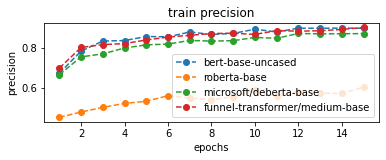

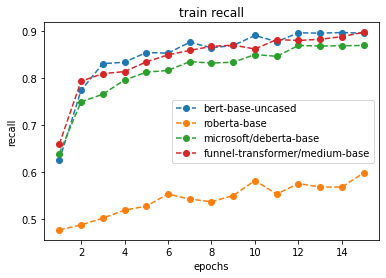

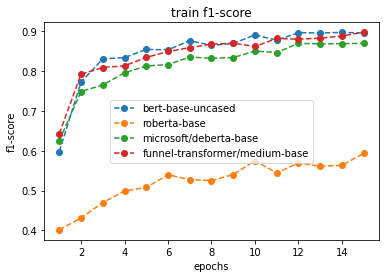

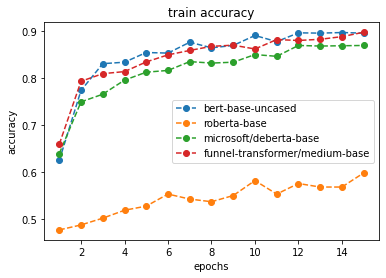

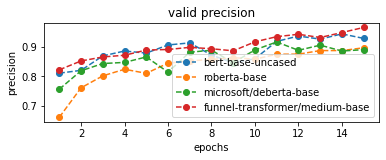

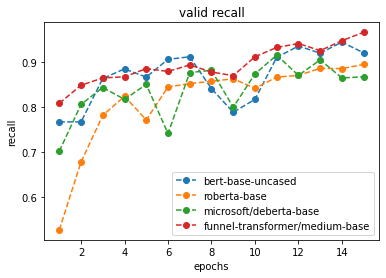

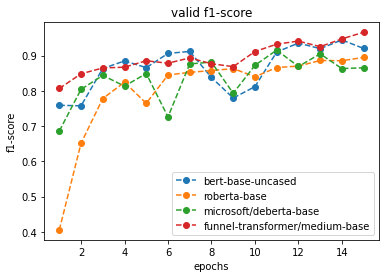

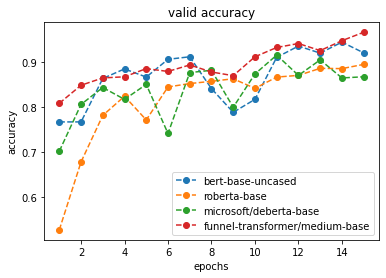

In [ ]:
stages = ['train', 'valid']
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
model_names = ['bert-base-uncased', 'roberta-base', 'microsoft/deberta-base', 'funnel-transformer/medium-base']

plot_results(report, stages, metrics, model_names) # LR = 1e-3, EPOCHS = 15